Motivation: Exploration of spare components

In [1]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn

In [2]:
from fft_conv_pytorch import fft_conv, FFTConv2d

In [3]:
imgI = np.load("/home/weniger/codes/pyrofit-lensing-analysis/mock_data/sources/antennae.npy")
imgI = np.load("/home/weniger/codes/pyrofit-lensing-analysis/mock_data/sources/hoags_object.npy")
imgI = skimage.transform.resize(imgI, [200, 200])

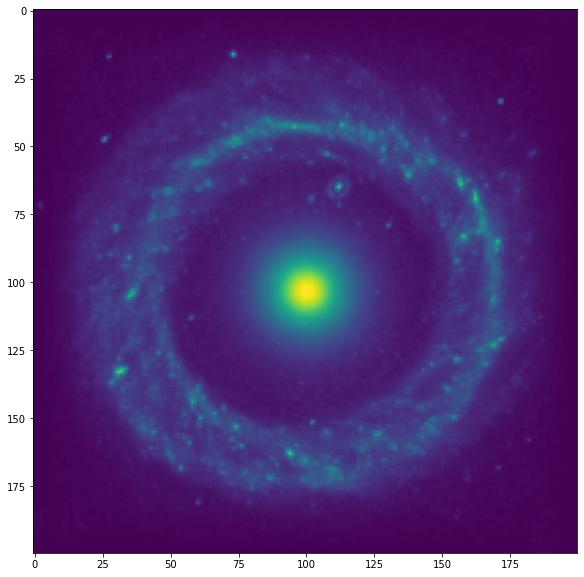

In [4]:
plt.figure(figsize = (10, 10))
plt.imshow(imgI)

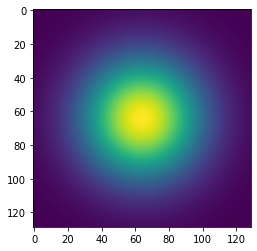

In [5]:
K = 129
channels = [0.5, 2.5, 25]
C = len(channels)

kernel = np.zeros((C, C, K, K))
x = np.linspace(-64, 64, K)
X, Y = np.meshgrid(x, x)
R = (X**2 + Y**2)**0.5

for i, s in enumerate(channels):
    kern = np.exp(-0.5*R**2/s**2)
    kern /= (kern**2).sum()**0.5
    kernel[i, i] = kern
    
plt.imshow(kernel[-1, -1])

In [6]:
kernel_gpu = torch.tensor(kernel).float()

In [51]:
gaussian_weights = nn.Parameter(kernel_gpu.cuda())
conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
with torch.no_grad():
    conv.weight = gaussian_weights

In [160]:
def model(seeds):
    seeds = seeds - torch.tensor([1., 2., 3.]).cuda().float().unsqueeze(1).unsqueeze(2)
    seeds = torch.nn.functional.leaky_relu(seeds, negative_slope = 0.0001)
    seeds = seeds * torch.tensor([.4, 2., 20.]).cuda().float().unsqueeze(1).unsqueeze(2)
    imgc = conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
    #imgc = torch.nn.functional.leaky_relu(imgc)
    #imgc = imgc.sum(axis = 0)
    img = imgc[2]*torch.exp(imgc[0])*torch.exp(imgc[1])
    return img*10

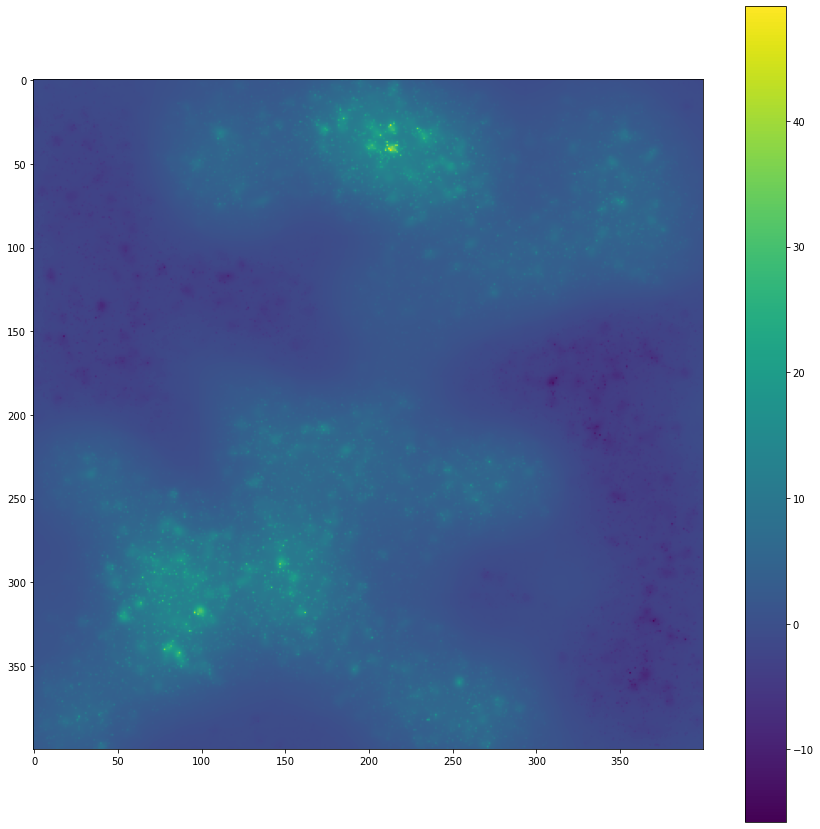

In [161]:
plt.figure(figsize=(15, 15))
imgr = model(torch.randn(C, 400, 400).cuda()).detach()
plt.imshow(imgr.detach().cpu())
plt.colorbar()

In [162]:
img0 = torch.tensor(imgI).float().cuda()*30

torch.Size([200, 200])

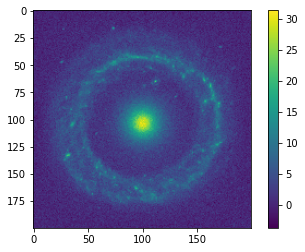

In [163]:
sigma= 1.0 * torch.ones_like(img0)
#sigma[100:120] += 10
noise = torch.randn(img0.shape).cuda()*sigma
img0n = img0+noise
plt.imshow(img0n.detach().cpu())
plt.colorbar()
img0n.shape

In [164]:
log_scales = torch.tensor([0.0, 0.0, 0.0]).cuda().float()
scales = torch.exp(log_scales)
seeds = torch.randn(3, 200, 200).cuda()*torch.exp(log_scales).unsqueeze(1).unsqueeze(2)
Gseeds = torch.ones_like(seeds)
Gscales = torch.ones_like(scales)*1e10
alpha = 0.99
losses1 = []
losses2 = []
losses3 = []
losses = []

In [ ]:
for epsilon in [1e-1, 1e-1, 1e-2, 1e-2, 1e-3, 1e-3]:
    print(epsilon)
    for _ in tqdm(range(1000)):
        seeds.requires_grad = True
        log_scales.requires_grad = True  # Flat prior in log space, drift towards small scales?
        
        scales = torch.exp(log_scales)
        img = model(seeds)
        
        # Image likelihood
        sn = 0.5*((img - img0n)**2)/sigma**2
        loss1 = torch.maximum(sn, torch.zeros_like(sn)).sum()
        
        # Seeds*scale density
        # N*STD - N*log(STD) --> 1 = 1/STD --> STD = 1
        loss2 = ((seeds*scales.unsqueeze(1).unsqueeze(2))**2).sum()*0.5
        
        # Sigma of seeds
        std = torch.std(seeds, [1, 2]).detach()
        loss3 = -200*200*torch.log(std*scales).sum()
        #loss3 -= torch.log(scales).sum()
        #loss3 -= (1000/scales).sum()
        
        # Loss backprop!
        loss = loss1 + loss2 + loss3
        loss.backward()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
        losses3.append(loss3.item())
        losses.append(loss.item())

        Gseeds = alpha*Gseeds + (1-alpha)*seeds.grad**2
        Gscales = alpha*Gscales + (1-alpha)*log_scales.grad**2
        Mseeds = 1/(Gseeds**0.5 + 1e-8)
        Mscales = 1/(Gscales**0.5 + 1e-8)
        
        seeds = seeds.detach() - epsilon*Mseeds*seeds.grad 
        seeds = seeds + torch.randn(seeds.size()).cuda()*(epsilon*Mseeds*2)**0.5
        
        log_scales = log_scales.detach() - epsilon*Mscales*log_scales.grad
        #scales = scales + torch.randn(scales.size()).cuda()*(epsilon*Mscales*2)**0.5
    print(losses1[-1], losses2[-1], losses3[-1], losses[-1])
    print(scales, alpha)
    #alpha = 1 - (1-alpha)*0.5
    
# Remaining scales drift seems to be associated with alpha < 1

  1%|          | 7/1000 [00:00<00:16, 61.47it/s]

0.1


  1%|          | 10/1000 [00:00<00:10, 90.02it/s]

824955.9375 58081.22265625 21442.10546875 904479.3125
tensor([1.9039, 0.9096, 0.1054], device='cuda:0', grad_fn=<ExpBackward>) 0.99
0.1


  1%|          | 10/1000 [00:00<00:10, 90.22it/s]

839295.75 57807.9296875 18187.1875 915290.875
tensor([2.1146, 1.0371, 0.0864], device='cuda:0', grad_fn=<ExpBackward>) 0.99
0.01


  1%|          | 9/1000 [00:00<00:11, 89.10it/s]

183032.34375 59743.2265625 16300.1669921875 259075.734375
tensor([1.1082, 0.6031, 0.0819], device='cuda:0', grad_fn=<ExpBackward>) 0.99
0.01


  1%|          | 9/1000 [00:00<00:11, 89.22it/s]

300953.15625 59683.703125 22051.595703125 382688.46875
tensor([1.2764, 0.6125, 0.0811], device='cuda:0', grad_fn=<ExpBackward>) 0.99
0.001


 58%|█████▊    | 585/1000 [00:06<00:04, 85.75it/s]

In [ ]:
c = 500
plt.plot(losses[c:])
plt.plot(losses1[c:])
plt.plot(losses2[c:])
plt.plot(losses3[c:])

In [ ]:
for i in range(C):
    s = (seeds[i]*scales[i]).cpu().detach().numpy().flatten()
    print(s.std())
    plt.hist(s, bins = 100);
scales

- Start -1: `tensor([0.3893, 0.2051, 0.0832], device='cuda:0', grad_fn=<ExpBackward>)`
- Start +1: `tensor([0.3866, 0.2110, 0.0797], device='cuda:0', grad_fn=<ExpBackward>)`
- Start 0 with mask: `tensor([0.3386, 0.1983, 0.1097], device='cuda:0', grad_fn=<ExpBackward>)`
That's actually pretty close!

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
img = model(seeds)
plt.imshow(img.detach().cpu())
plt.colorbar()
plt.subplot(122)
plt.imshow(img0n.detach().cpu())
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow((img.detach().cpu() - img0n.detach().cpu())/sigma.cpu(), vmin = -2, vmax = 2, cmap = 'coolwarm')
plt.colorbar()
plt.subplot(122)
plt.imshow((img0.detach().cpu() - img0n.detach().cpu())/sigma.cpu(), vmin = -2, vmax = 2, cmap = 'coolwarm')
plt.colorbar()